# Process All Data
Get all of the data together. This includes data during formation and aging cycles. Aging cycles include the diagnostic tests as well as the 1C/1C charge/discharge. Summarize the results and plot correlations.

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code-base':
    os.chdir('../')
sys.path.append('code-base')

import numpy as np
import pandas as pd
import glob
import pprint
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt
import re
from src.formation import FormationCell

In [2]:
assert os.path.basename(os.getcwd()) == 'project-formation'

In [3]:
pd.set_option('display.max_rows', 500)

## Configure plot settings

In [4]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)
GREY = (0.9, 0.9, 0.9)

## Load resources

In [5]:
formation_cells = []
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    formation_cells.append(FormationCell(cellid))
    
for cell in formation_cells:
    print(cell)

Formation Cell 1
Formation Cell 2
Formation Cell 3
Formation Cell 4
Formation Cell 5
Formation Cell 6
Formation Cell 7
Formation Cell 8
Formation Cell 9
Formation Cell 10
Formation Cell 11
Formation Cell 12
Formation Cell 13
Formation Cell 14
Formation Cell 15
Formation Cell 16
Formation Cell 17
Formation Cell 18
Formation Cell 19
Formation Cell 20
Formation Cell 21
Formation Cell 22
Formation Cell 23
Formation Cell 24
Formation Cell 25
Formation Cell 26
Formation Cell 27
Formation Cell 28
Formation Cell 29
Formation Cell 30
Formation Cell 31
Formation Cell 32
Formation Cell 33
Formation Cell 34
Formation Cell 35
Formation Cell 36
Formation Cell 37
Formation Cell 38
Formation Cell 39
Formation Cell 40


## Plot cycles to x% Retention

In [6]:
# Get the data
results_list = []

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue

    print(f'Processing cell {cell}...')

    stats_dict = cell.get_aging_test_summary_statistics()

    for retention in np.array([50, 60, 70, 80]):

        curr_dict = dict()
        curr_dict['cellid'] = cell.cellid
        curr_dict['is_room_temp'] = cell.is_room_temp()
        curr_dict['formation_type'] = 'Baseline Formation' if cell.is_baseline_formation() else 'Fast Formation'
        curr_dict['retention'] = retention
        curr_dict['cycles'] = stats_dict[f'cycles_to_{retention}_pct']
            
        results_list.append(curr_dict)
        
df = pd.DataFrame(results_list)
df['retention'] = df['retention'].astype('category')


df_room_temp = df[df['is_room_temp'] == 1]
df_high_temp = df[df['is_room_temp'] == 0]

Processing cell Formation Cell 1...
Processing cell Formation Cell 2...
Processing cell Formation Cell 3...
Processing cell Formation Cell 4...
Processing cell Formation Cell 5...
Processing cell Formation Cell 6...
Processing cell Formation Cell 7...
Processing cell Formation Cell 8...
Processing cell Formation Cell 10...
Processing cell Formation Cell 11...
Processing cell Formation Cell 12...
Processing cell Formation Cell 13...
Processing cell Formation Cell 14...
Processing cell Formation Cell 15...
Processing cell Formation Cell 16...
Processing cell Formation Cell 17...
Processing cell Formation Cell 18...
Processing cell Formation Cell 19...
Processing cell Formation Cell 20...
Processing cell Formation Cell 21...
Processing cell Formation Cell 22...
Processing cell Formation Cell 23...
Processing cell Formation Cell 24...
Processing cell Formation Cell 25...
Processing cell Formation Cell 26...
Processing cell Formation Cell 27...
Processing cell Formation Cell 28...
Processin

### How does the variability change given different definitions of end of life retention?

In [7]:
df.to_csv('end_of_life_retention.csv')

In [8]:
std_over_mean = lambda x: np.std(x) / np.mean(x)
iqr_over_mean = lambda x: (np.percentile(x, 75) - np.percentile(x, 25)) / np.median(x)
iqr = lambda x: np.percentile(x, 75) - np.percentile(x, 25)
this_df = df.drop(columns=['cellid'])
this_df = this_df.groupby(['is_room_temp', 'formation_type', 'retention']) \
                 .agg(['mean', 'std', std_over_mean, iqr, iqr_over_mean])['cycles']
this_df

mean        std  <lambda_0>  \
is_room_temp formation_type     retention                                      
False        Baseline Formation 50         423.111111  39.001424    0.086906   
                                60         410.111111  37.321055    0.085798   
                                70         379.666667  33.548472    0.083309   
                                80         338.444444  21.880991    0.060954   
             Fast Formation     50         524.200000  45.266618    0.081922   
                                60         511.700000  46.180924    0.085619   
                                70         491.300000  46.212192    0.089234   
                                80         405.400000  31.672631    0.074118   
True         Baseline Formation 50         429.600000  29.620563    0.065411   
                                60         399.700000  36.712244    0.087136   
                                70         358.700000  26.415694    0.069864   
                                80         326.500000  24.084343    0.069980   
             Fast Formation     50         551.900000  58.014270    0.099723   
                                60         517.700000  56.566676    0.103658   
                                70         467.100000  42.680857    0.086685   
                                80         414.900000  38.036386    0.086972   

                                           <lambda_1>  <lambda_2>  
is_room_temp formation_type     retention                          
False        Baseline Formation 50              29.00    0.070388  
                                60              30.00    0.074627  
                                70              19.00    0.050938  
                                80              12.00    0.035714  
             Fast Formation     50              53.00    0.101630  
                                60              56.75    0.111493  
                                70              55.75    0.116146  
                                80              24.00    0.059701  
True         Baseline Formation 50              35.75    0.082947  
                                60              17.50    0.043805  
                                70              28.25    0.078911  
                                80              31.75    0.097542  
             Fast Formation     50              80.00    0.140598  
                                60              61.50    0.113994  
                                70              41.25    0.084877  
                                80              40.50    0.093859

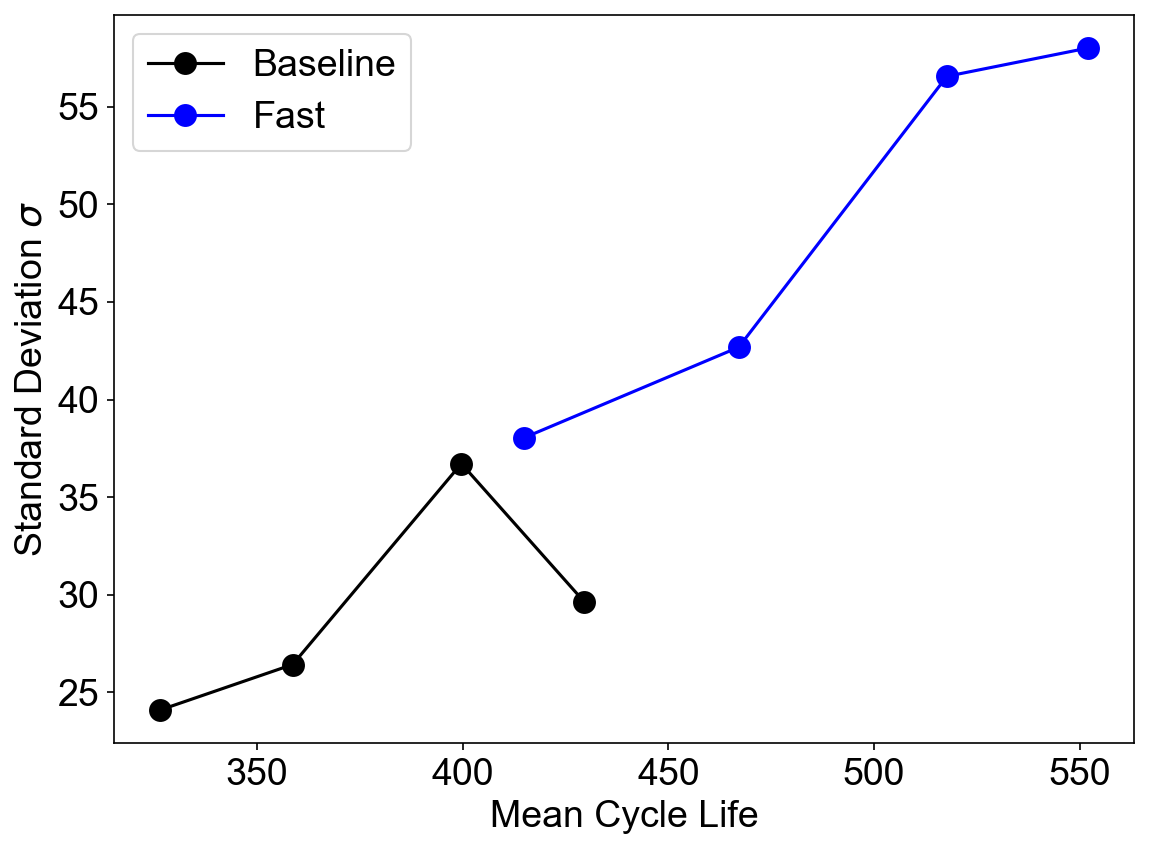

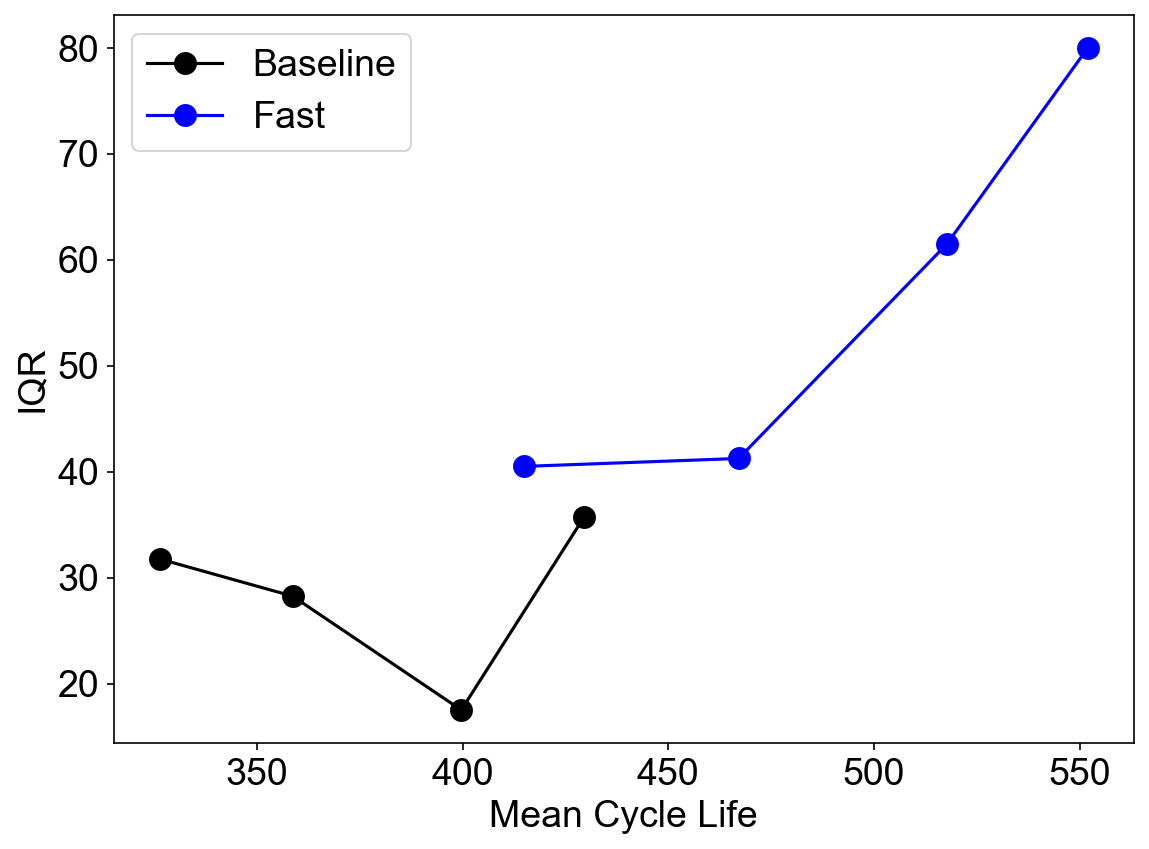

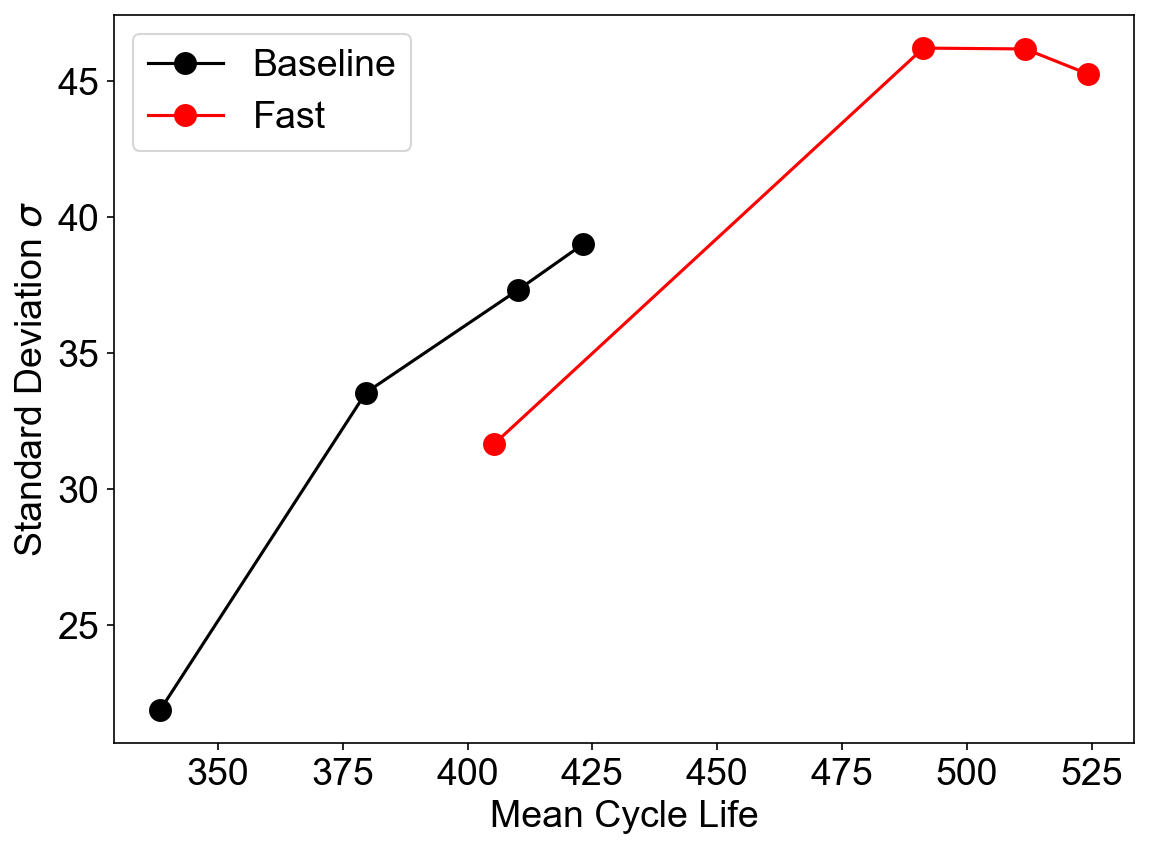

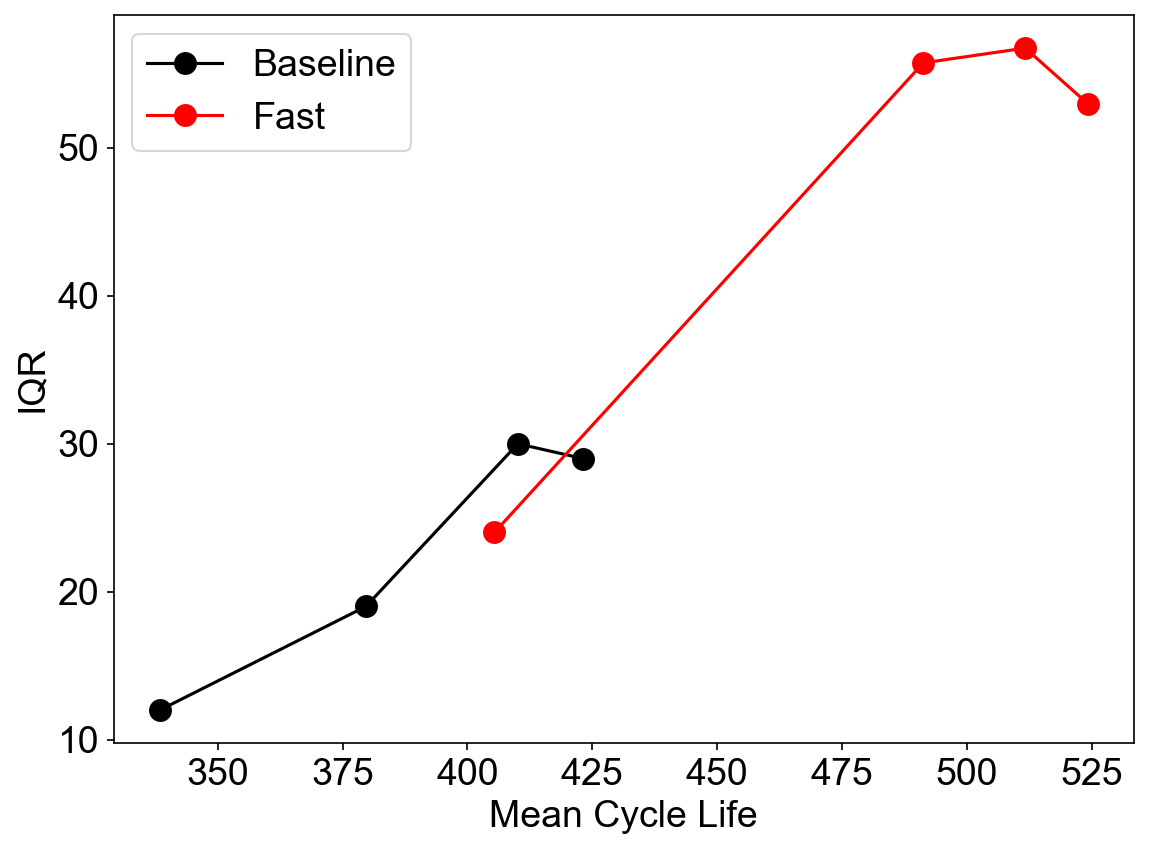

In [9]:
for is_room_temp in [True, False]:
  
    ret_base = this_df.loc[is_room_temp, 'Baseline Formation'].index.values
    mean_base = this_df.loc[is_room_temp, 'Baseline Formation']['mean']
    std_base = this_df.loc[is_room_temp, 'Baseline Formation']['std']
    cv_base = this_df.loc[is_room_temp, 'Baseline Formation']['<lambda_0>']
    iqr_base = this_df.loc[is_room_temp, 'Baseline Formation']['<lambda_1>']
    iqr_over_mean_base = this_df.loc[is_room_temp, 'Baseline Formation']['<lambda_2>']

    ret_fast = this_df.loc[is_room_temp, 'Fast Formation'].index.values
    mean_fast = this_df.loc[is_room_temp, 'Fast Formation']['mean']
    std_fast = this_df.loc[is_room_temp, 'Fast Formation']['std']
    cv_fast = this_df.loc[is_room_temp, 'Fast Formation']['<lambda_0>']
    iqr_fast = this_df.loc[is_room_temp, 'Fast Formation']['<lambda_1>']
    iqr_over_mean_fast = this_df.loc[is_room_temp, 'Fast Formation']['<lambda_2>']

    col = 'b' if is_room_temp else 'r'
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(mean_base, std_base, 'o-', markersize=10, color='k', label='Baseline')
    ax.plot(mean_fast, std_fast, 'o-', markersize=10, color=col, label='Fast')
    ax.grid(False)
    ax.set_xlabel('Mean Cycle Life')
    ax.set_ylabel('Standard Deviation $\sigma$')
    ax.legend()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(mean_base, iqr_base, 'o-', markersize=10, color='k', label='Baseline')
    ax.plot(mean_fast, iqr_fast, 'o-', markersize=10, color=col, label='Fast')
    ax.grid(False)
    ax.set_xlabel('Mean Cycle Life')
    ax.set_ylabel('IQR')
    ax.legend()



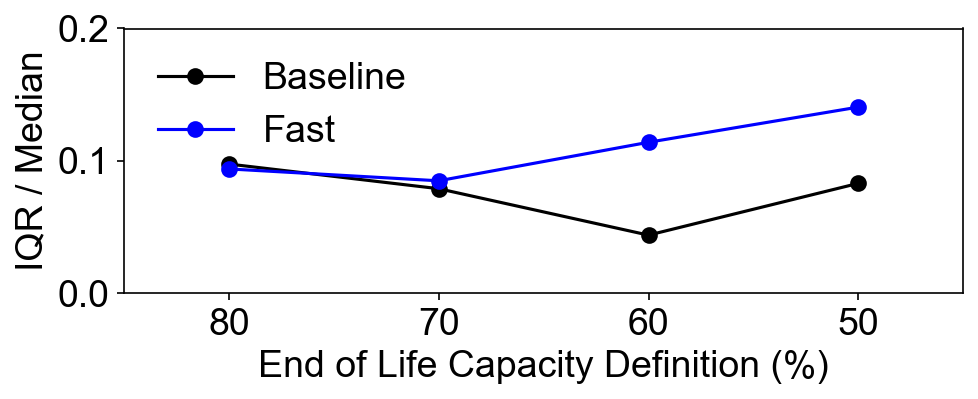

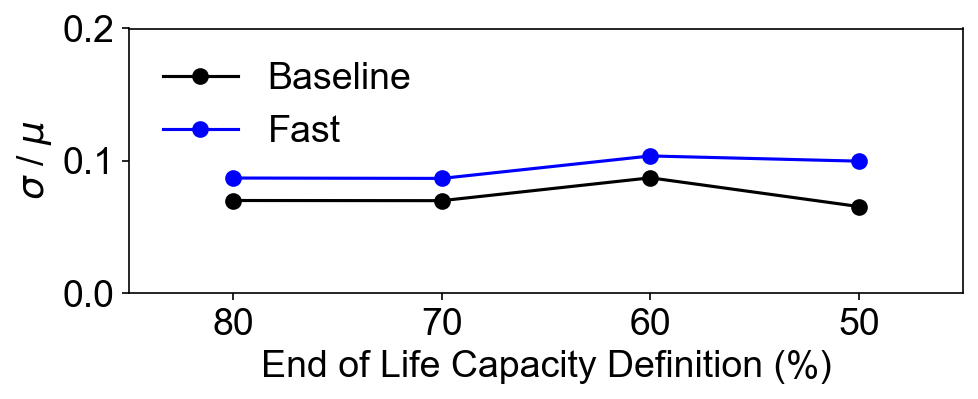

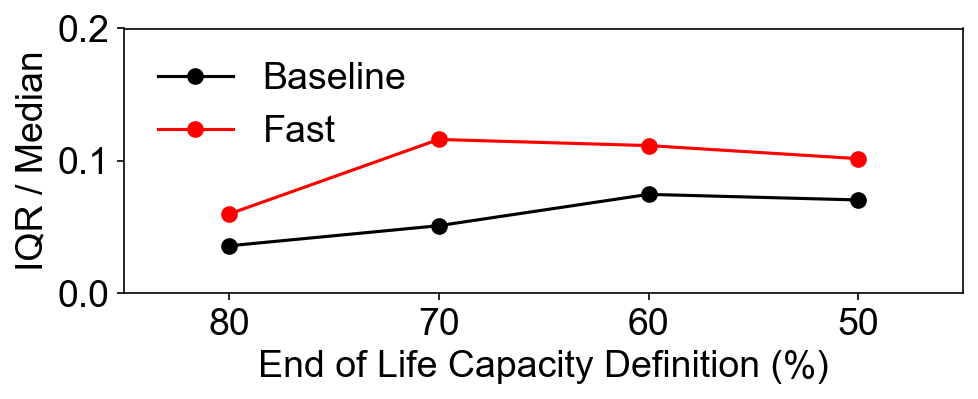

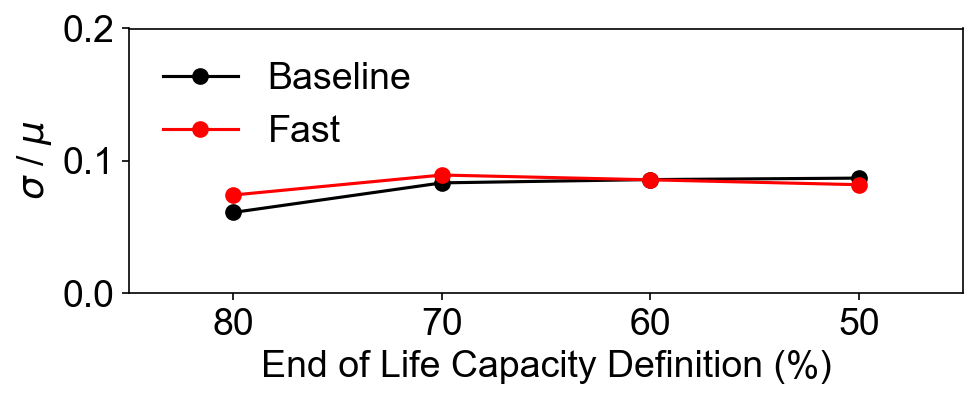

In [10]:
for is_room_temp in [True, False]:
  
    ret_base = this_df.loc[is_room_temp, 'Baseline Formation'].index.values
    mean_base = this_df.loc[is_room_temp, 'Baseline Formation']['mean']
    std_base = this_df.loc[is_room_temp, 'Baseline Formation']['std']
    cv_base = this_df.loc[is_room_temp, 'Baseline Formation']['<lambda_0>']
    iqr_base = this_df.loc[is_room_temp, 'Baseline Formation']['<lambda_1>']
    iqr_over_mean_base = this_df.loc[is_room_temp, 'Baseline Formation']['<lambda_2>']

    ret_fast = this_df.loc[is_room_temp, 'Fast Formation'].index.values
    mean_fast = this_df.loc[is_room_temp, 'Fast Formation']['mean']
    std_fast = this_df.loc[is_room_temp, 'Fast Formation']['std']
    cv_fast = this_df.loc[is_room_temp, 'Fast Formation']['<lambda_0>']
    iqr_fast = this_df.loc[is_room_temp, 'Fast Formation']['<lambda_1>']
    iqr_over_mean_fast = this_df.loc[is_room_temp, 'Fast Formation']['<lambda_2>']

    col = 'b' if is_room_temp else 'r'
    
    fig, ax = plt.subplots(figsize=(7,3))
    ax.plot(ret_base, iqr_over_mean_base, 'o-', markersize=7, color='k', label='Baseline')
    ax.plot(ret_fast, iqr_over_mean_fast, 'o-', markersize=7, color=col, label='Fast')
    ax.grid(False)
    ax.set_xlim((85, 45))
    ax.set_ylim((0, 0.2))
    ax.set_xlabel('End of Life Capacity Definition (%)')
    ax.set_ylabel('IQR / Median')
    ax.legend(prop={'size': 18}, frameon=False, loc='upper left')
    ax.set_xticks([80, 70, 60, 50])

    fig, ax = plt.subplots(figsize=(7,3))
    ax.plot(ret_base, cv_base, 'o-', markersize=7, color='k', label='Baseline')
    ax.plot(ret_fast, cv_fast, 'o-', markersize=7, color=col, label='Fast')
    ax.grid(False)
    ax.set_xlim((85, 45))
    ax.set_ylim((0, 0.2))
    ax.set_xlabel('End of Life Capacity Definition (%)')
    ax.set_ylabel('$\sigma$ / $\mu$')
    ax.legend(prop={'size': 18}, frameon=False, loc='upper left')
    ax.set_xticks([80, 70, 60, 50])


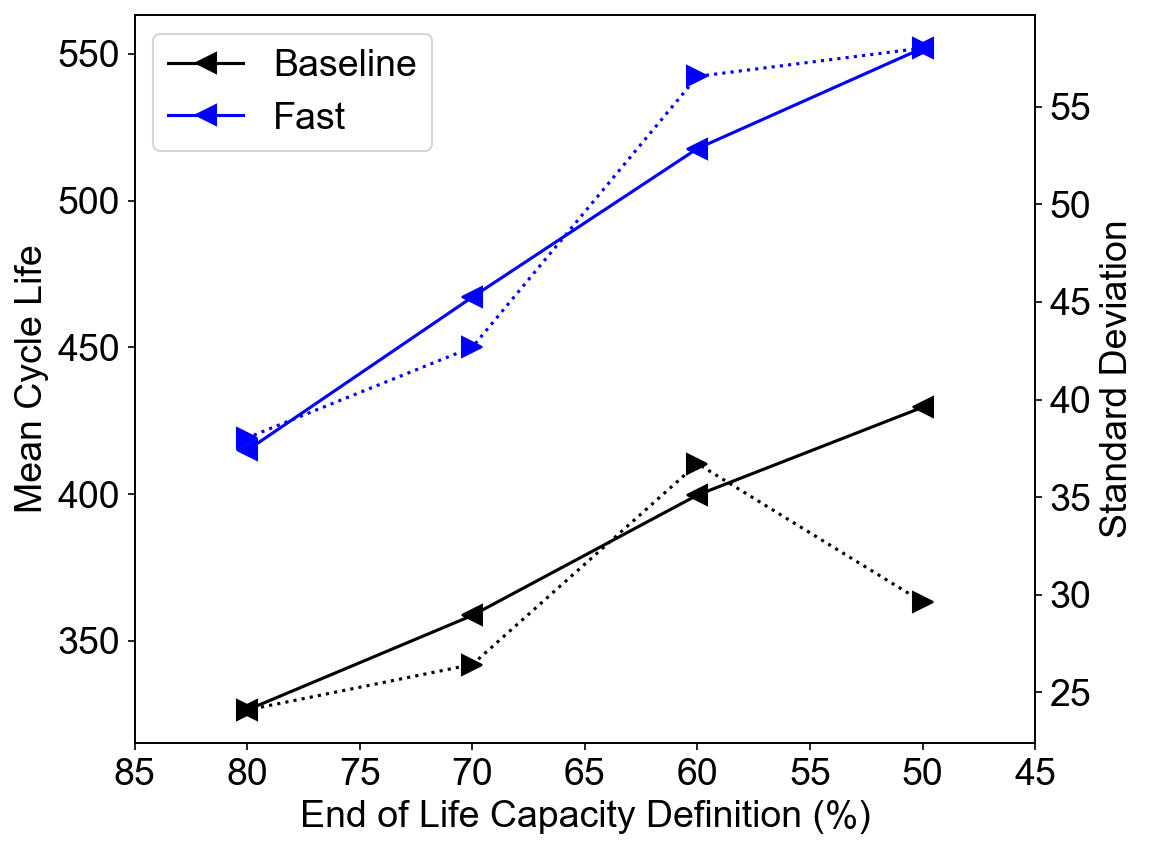

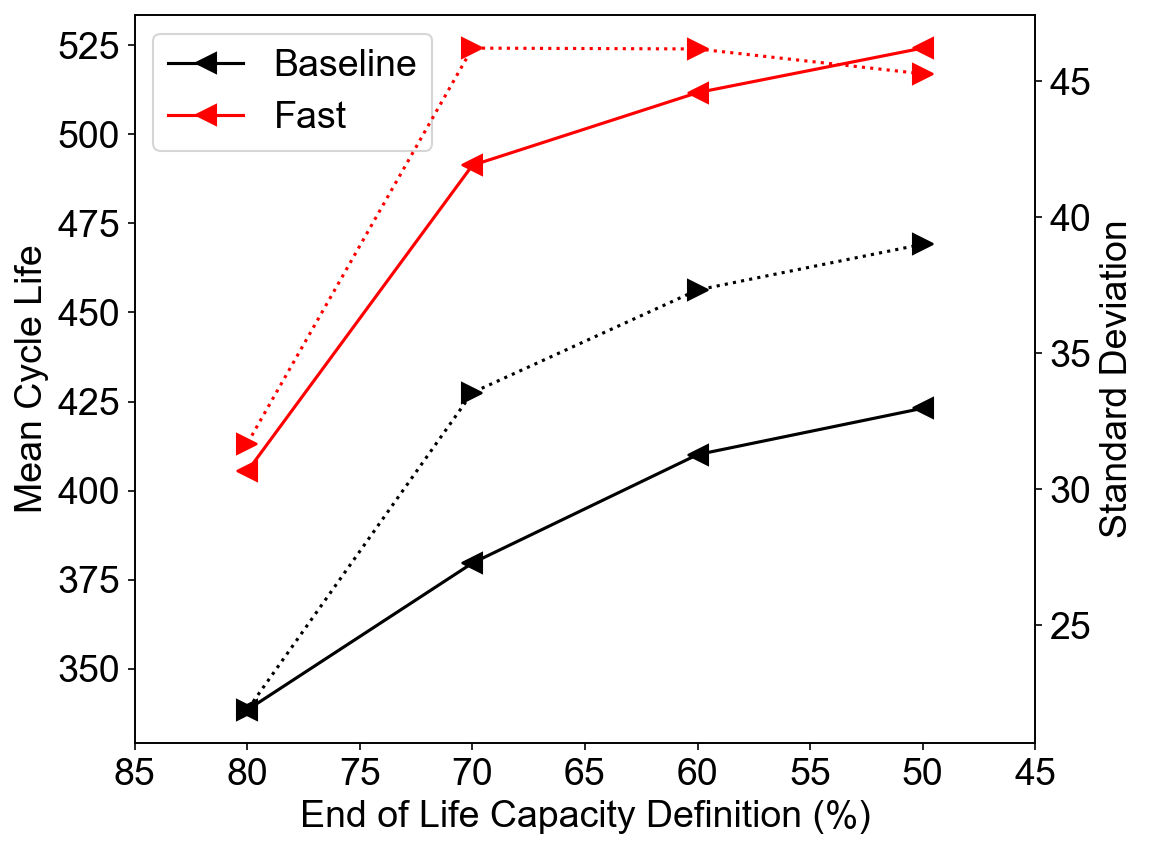

In [11]:
# Room temperature

for is_room_temp in [True, False]:

    ret_base = this_df.loc[is_room_temp, 'Baseline Formation'].index.values
    mean_base = this_df.loc[is_room_temp, 'Baseline Formation']['mean']
    std_base = this_df.loc[is_room_temp, 'Baseline Formation']['std']
    iqr_base = this_df.loc[is_room_temp, 'Baseline Formation']['<lambda_1>']
    cv_base = this_df.loc[is_room_temp, 'Baseline Formation']['<lambda_0>']

    ret_fast = this_df.loc[is_room_temp, 'Fast Formation'].index.values
    mean_fast = this_df.loc[is_room_temp, 'Fast Formation']['mean']
    std_fast = this_df.loc[is_room_temp, 'Fast Formation']['std']
    iqr_fast = this_df.loc[is_room_temp, 'Fast Formation']['<lambda_1>']
    cv_fast = this_df.loc[is_room_temp, 'Fast Formation']['<lambda_0>']

    fig, ax = plt.subplots(figsize=(8, 6))

    color = 'b' if is_room_temp else 'r'
    
    ax2 = ax.twinx()

    ax.plot(ret_base, mean_base, '<-', markersize=10, color='k', label='Baseline')
    ax.plot(ret_fast, mean_fast, '<-', markersize=10, color=color, label='Fast')

    ax2.plot(ret_base, std_base, '>:', markersize=10, color='k', label='Baseline')
    ax2.plot(ret_fast, std_fast, '>:', markersize=10, color=color, label='Fast')


    ax.set_xlim((85, 45))
    ax.grid(False)
    ax.set_xlabel('End of Life Capacity Definition (%)')
    ax.set_ylabel('Mean Cycle Life')
    ax.legend()

    ax2.grid(False)
    ax2.set_ylabel('Standard Deviation')

## Make the aging variability plot vertically

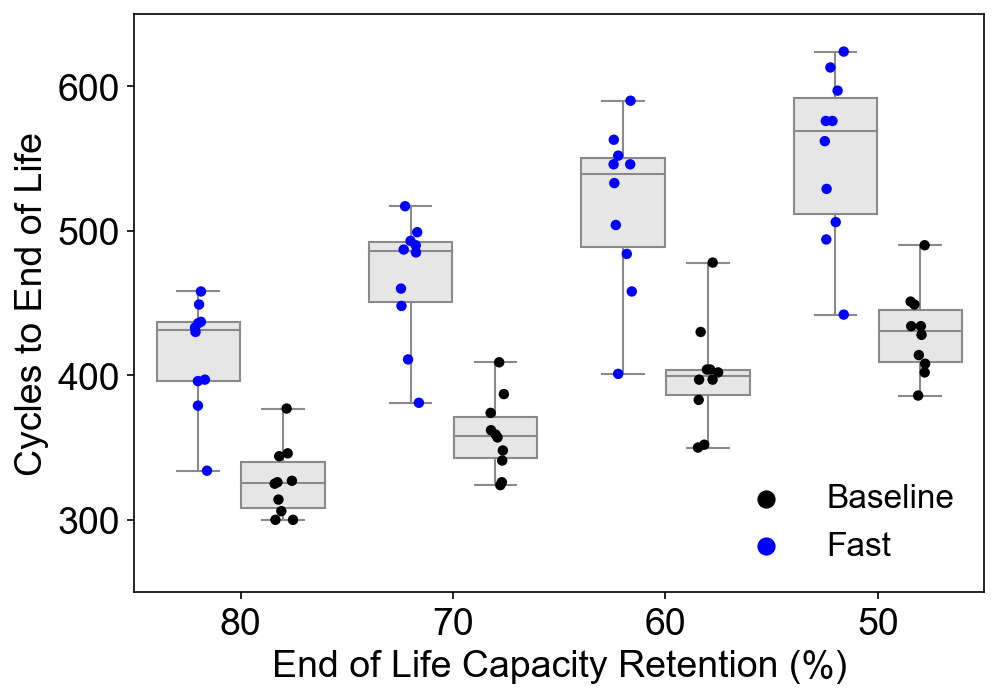

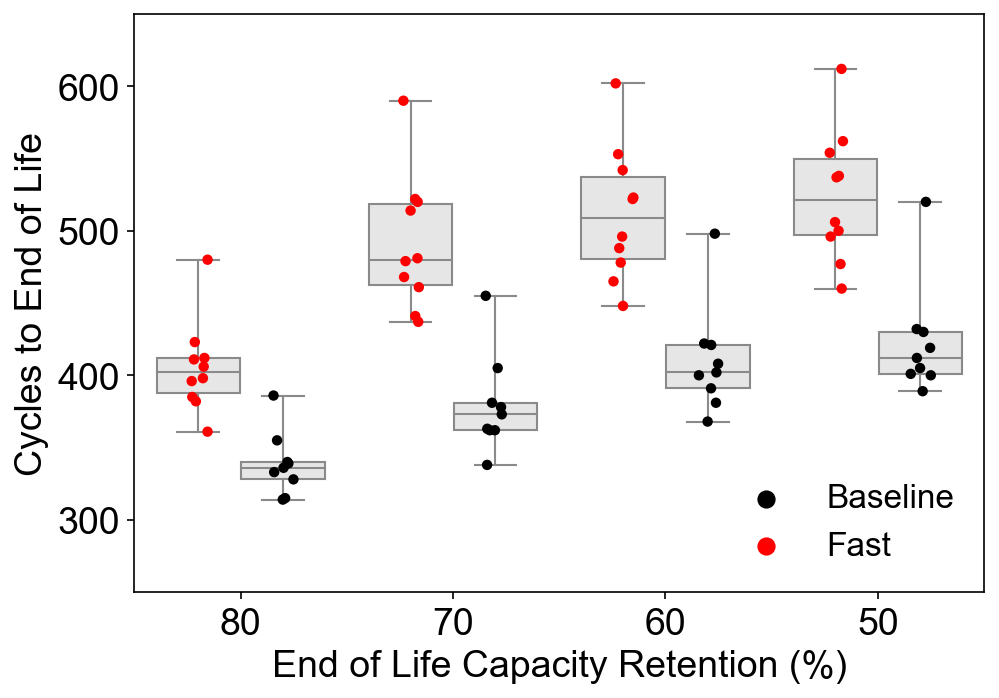

In [12]:
for data_df, color, color2 in zip([df_room_temp, df_high_temp], 
                            [(0.8, 0.8, 1), (1, 0.8, 0.8)],
                            ['b', 'r']):
    
    plt.figure(figsize=(7,5))

    bp = sns.boxplot(x='retention', y='cycles',
                     data=data_df,
                     palette=[GREY, GREY],
                     hue='formation_type',
                     showfliers=False,
                     whis=1e9,
                     linewidth=1
                    )

    bp = sns.stripplot(x='retention', y='cycles', 
                       data=data_df, 
                       jitter=True,
                       dodge=True, 
                       marker='o',
                       palette=['black', color2],
                       hue='formation_type',
                       alpha=1)

    bp.invert_xaxis()
    
    bp.set(ylabel='Cycles to End of Life',
           xlabel='End of Life Capacity Retention (%)',
           title='',
           ylim=(250,650))

    ax = plt.gca()
    ax.grid(False)

    handles, labels = bp.get_legend_handles_labels()
    l = plt.legend(handles[2:4], ['Baseline', 'Fast'], 
                   prop={'size': 16}, 
                   frameon=False,
                   loc='lower right')

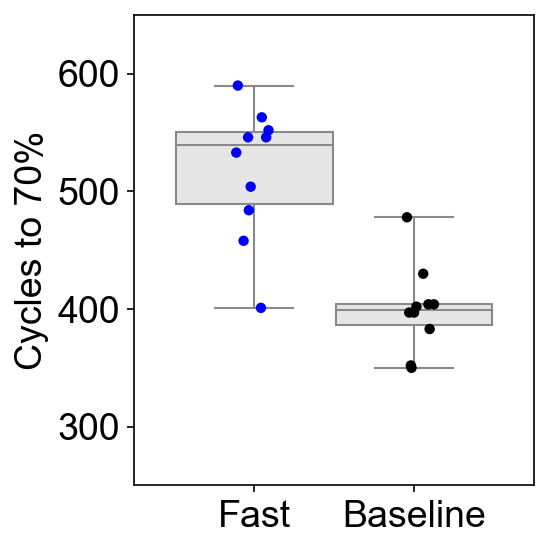

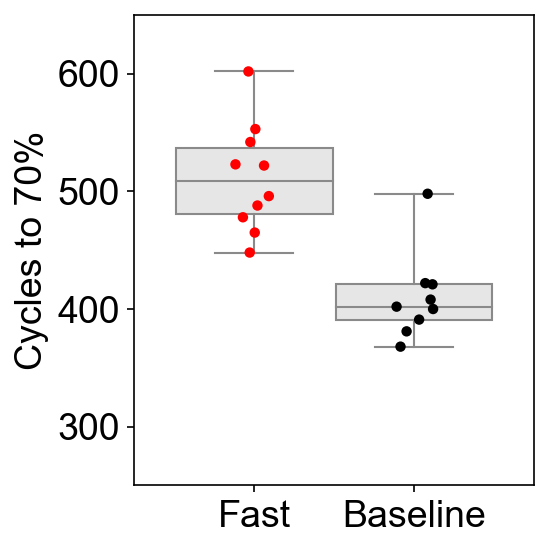

In [13]:
for data_df, color, color2 in zip([df_room_temp, df_high_temp], 
                            [(0.8, 0.8, 1), (1, 0.8, 0.8)],
                            ['b', 'r']):
    
    plt.figure(figsize=(4, 4))

    bp = sns.boxplot(x='retention', y='cycles',
                     data=data_df,
                     palette=[GREY, GREY],
                     hue='formation_type',
                     showfliers=False,
                     whis=1e9,
                     linewidth=1
                    ) 

    bp = sns.stripplot(x='retention', y='cycles', 
                       data=data_df, 
                       jitter=True,
                       dodge=True, 
                       marker='o',
                       palette=['black', color2],
                       hue='formation_type',
                       alpha=1)

    bp.invert_xaxis()
    
    bp.set(ylabel='Cycles to 70%',
           xlabel='',
           title='',
           ylim=(250,650),
           xlim=(1.5, 0.5))

    ax = plt.gca()
    ax.grid(False)
    
    ax.set_xticks([1.2, 0.80])
    ax.set_xticklabels(['Fast', 'Baseline'])
    plt.legend().remove()

## Make the aging variability plot horizontally

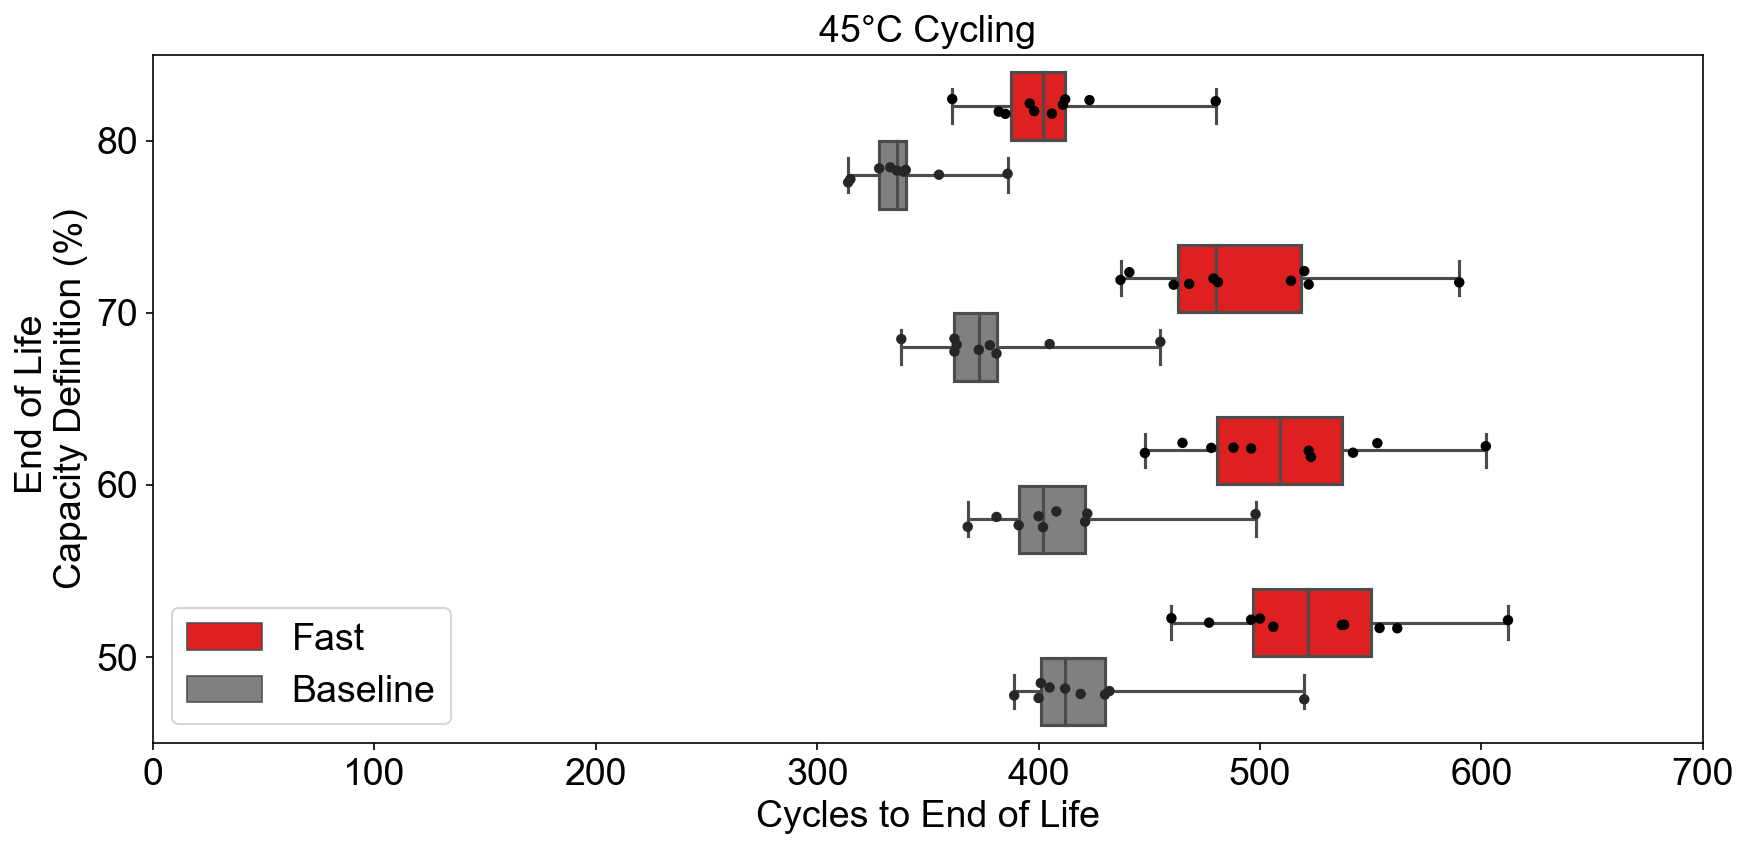

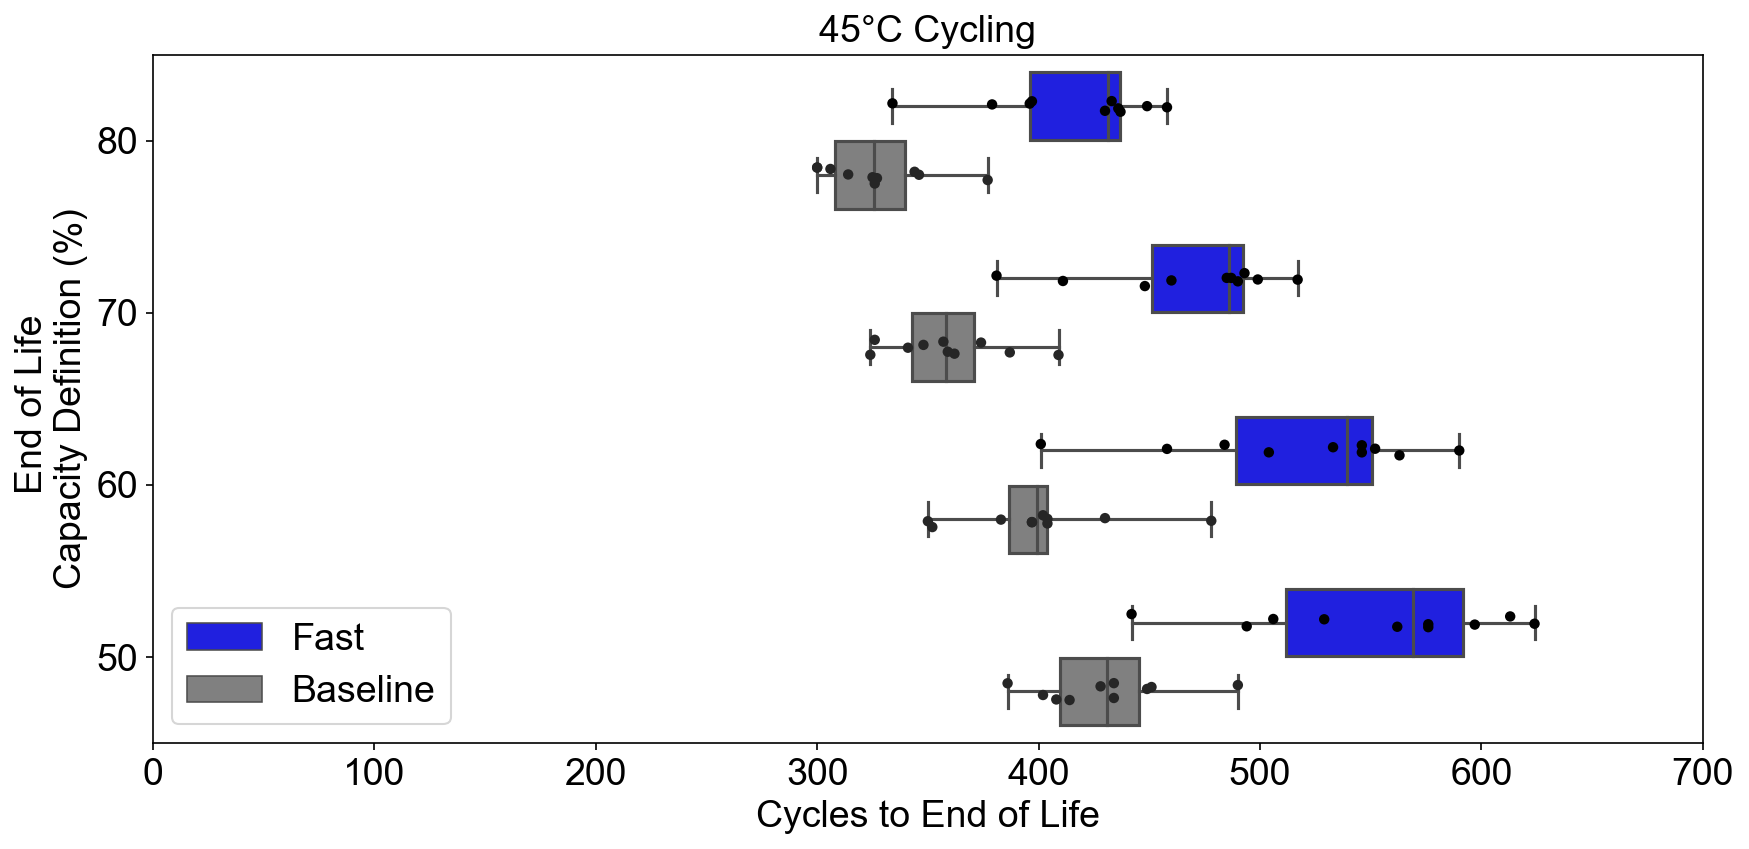

In [14]:
for data_df, color in zip([df_high_temp, df_room_temp], ['r', 'b']):

    plt.figure(figsize=(12,6))

    bp = sns.boxplot(x='cycles', y='retention',
                     data=data_df,
                     palette=['grey', color],
                     hue='formation_type',
                     showfliers=False,
                     whis=5
                    )

    bp = sns.stripplot(x='cycles', y='retention', 
                       data=data_df, 
                       jitter=True,
                       dodge=True, 
                       marker='o', 
                       alpha=1,
                       hue='formation_type',
                       color='black')

    bp.set(xlabel='Cycles to End of Life',
           ylabel='End of Life \nCapacity Definition (%)',
           title='45°C Cycling',
           xlim=(0,700))

    bp.invert_yaxis()

    ax = plt.gca()
    ax.grid(False)

    handles, labels = bp.get_legend_handles_labels()
    l = plt.legend(handles[0:2][::-1], 
                   ['Baseline', 'Fast', 'Baseline', 'Fast'][::-1], 
                   loc='lower left')

In [15]:
labels

['Baseline Formation',
 'Fast Formation',
 'Baseline Formation',
 'Fast Formation']

## Compute statistical significance for cycles to x% retention

In [16]:
result = list()

for ret in df.retention.unique():
    
    for is_room_temp in [0, 1]:
        
        df_subset = df[(df['retention'] == ret) & 
                       (df['is_room_temp'] == is_room_temp)]

        set_fast = df_subset[df_subset['formation_type'] == 'Fast Formation']['cycles'].dropna()
        set_baseline = df_subset[df_subset['formation_type'] == 'Baseline Formation']['cycles'].dropna()

        stat, p = ttest_ind(set_fast, set_baseline)

        curr_result = dict()
        curr_result['retention_target'] = ret
        curr_result['p_value'] = p
        curr_result['is_room_temp'] = is_room_temp
        curr_result['temp'] = 'rt' if is_room_temp else 'ht'
        curr_result['stdev_fast'] = np.std(set_fast)
        curr_result['stdev_base'] = np.std(set_baseline)

        result.append(curr_result)

df_result = pd.DataFrame(result)

display(df_result)


,retention_target,p_value,is_room_temp,temp,stdev_fast,stdev_base
0,50,0.000075,0,ht,42.943684,36.770896
1,50,0.000013,1,rt,55.037169,28.100534
2,60,0.000067,0,ht,43.811072,35.186628
3,60,0.000030,1,rt,53.663861,34.828293
4,70,0.000015,0,ht,43.840734,31.629803
5,70,0.000002,1,rt,40.490616,25.060128
6,80,0.000059,0,ht,30.047296,20.629596
7,80,0.000007,1,rt,36.084484,22.848414


In [17]:
df

,cellid,is_room_temp,formation_type,retention,cycles
0,1,False,Baseline Formation,50,400
1,1,False,Baseline Formation,60,391
2,1,False,Baseline Formation,70,373
3,1,False,Baseline Formation,80,328
4,2,False,Baseline Formation,50,401
5,2,False,Baseline Formation,60,368
6,2,False,Baseline Formation,70,338
7,2,False,Baseline Formation,80,314
8,3,False,Baseline Formation,50,520
9,3,False,Baseline Formation,60,498


## Process the data from the Diagnostic Cycles

## Load the eSOH Parameters

In [18]:
ESOH_FILE = 'output//summary_esoh_table.csv'

df_esoh = pd.read_csv(ESOH_FILE)

# Exclude cell 9
df_esoh = df_esoh[df_esoh['cellid'] != 9]

# Exclude high RMSE
# df_esoh = df_esoh[df_esoh['RMSE_mV'] < 120]

df_esoh = df_esoh.sort_values(by=['cellid', 'cycle_number'])

# Compute more metrics
df_esoh = df_esoh.merge(df_esoh.groupby(['cellid'])['n_li'].first().rename('n_li_0'), on='cellid')
df_esoh = df_esoh.merge(df_esoh.groupby(['cellid'])['Cp'].first().rename('Cp_0'), on='cellid')
df_esoh = df_esoh.merge(df_esoh.groupby(['cellid'])['Cn'].first().rename('Cn_0'), on='cellid')
df_esoh = df_esoh.merge(df_esoh.groupby(['cellid'])['Qfull'].first().rename('Qfull_0'), on='cellid')

df_esoh['lli'] = (1 - df_esoh['n_li'] / df_esoh['n_li_0']) * 100
df_esoh['lam_pe'] = (1 - df_esoh['Cp'] / df_esoh['Cp_0']) * 100
df_esoh['lam_ne'] = (1 - df_esoh['Cn'] / df_esoh['Cn_0']) * 100
df_esoh['c20_loss'] = (1 - df_esoh['Qfull'] / df_esoh['Qfull_0']) * 100

df_esoh_rt_base = df_esoh[df_esoh['cellid'].isin([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])]
df_esoh_rt_fast = df_esoh[df_esoh['cellid'].isin([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]
df_esoh_ht_base = df_esoh[df_esoh['cellid'].isin([1, 2, 3, 4, 5, 6, 7, 8])] # Exclude cell #9
df_esoh_ht_fast = df_esoh[df_esoh['cellid'].isin([31, 32, 33, 34, 35, 36, 37, 38, 39, 40])]

In [24]:
# Define helper function here

def add_mean_line(ax, df, varname, color):
    
    df_mean = df.groupby('cycle_number').mean()
    df_std = df.groupby('cycle_number').std()
    
    std = df_std[varname]
    mean = df_mean[varname]
    
    ax.plot(df_mean.index, mean, 
            linewidth=2.5, 
            color=color, 
            marker='o', 
            markersize=4)
    
#     ax.fill_between(df_mean.index, (mean - 2*std), (mean + 2*std), 
#                     color=color, 
#                     alpha=0.1, 
#                     linewidth=0.0)

In [20]:
# Build a full list of HPPC data for all cells

df_hppc_all = pd.DataFrame()

df_hppc_list = []

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    (df_hppc, _) = cell.summarize_hppc_pulse_statistics()
    df_hppc['cellid'] = cell.cellid
    df_hppc['cycle_number'] = df_hppc['cycle_index']
    df_hppc['dcr_10s_soc_5']*=1000;
    df_hppc['dcr_10s_soc_50']*=1000;
    df_hppc['dcr_10s_soc_100']*=1000;
    df_hppc_list.append(df_hppc)
    
df_hppc_all = pd.concat(df_hppc_list)

df_hppc_rt_base = df_hppc_all[df_hppc_all['cellid'].isin([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])]
df_hppc_rt_fast = df_hppc_all[df_hppc_all['cellid'].isin([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]
df_hppc_ht_base = df_hppc_all[df_hppc_all['cellid'].isin([1, 2, 3, 4, 5, 6, 7, 8])] # Exclude cell #9
df_hppc_ht_fast = df_hppc_all[df_hppc_all['cellid'].isin([31, 32, 33, 34, 35, 36, 37, 38, 39, 40])]

In [21]:
df_hppc

,cycle_index,dcr_10s_soc_0,dcr_3s_soc_0,dcr_1s_soc_0,dcr_10s_soc_5,dcr_3s_soc_5,dcr_1s_soc_5,dcr_10s_soc_7,dcr_3s_soc_7,dcr_1s_soc_7,...,dcr_3s_soc_70,dcr_1s_soc_70,dcr_10s_soc_90,dcr_3s_soc_90,dcr_1s_soc_90,dcr_10s_soc_100,dcr_3s_soc_100,dcr_1s_soc_100,cellid,cycle_number
0,4,0.051378,0.034349,0.026985,44.422261,0.030668,0.024626,0.032277,0.024241,0.020508,...,0.012290,0.010938,0.015539,0.012256,0.010934,16.095235,0.012522,0.011106,40,4
1,57,0.036338,0.027101,0.023064,33.604932,0.025575,0.022002,0.028086,0.022493,0.019856,...,0.014049,0.012794,0.017038,0.013886,0.012606,17.384179,0.014068,0.012684,40,57
2,160,0.029553,0.022575,0.019874,28.245412,0.021915,0.019439,0.025068,0.020311,0.018381,...,0.015845,0.014543,0.018756,0.015534,0.014199,19.091074,0.015743,0.014294,40,160
3,263,0.030360,0.023637,0.021020,29.485060,0.023220,0.020763,0.026790,0.021938,0.019973,...,0.018071,0.016628,0.020960,0.017557,0.016195,21.247084,0.017706,0.016257,40,263
4,366,0.034284,0.027117,0.024345,33.701080,0.026838,0.024169,0.031099,0.025590,0.023384,...,0.021483,0.019842,0.024261,0.020688,0.019217,24.527501,0.020770,0.019257,40,366
5,469,0.043197,0.035238,0.032265,43.197070,0.035238,0.032265,0.040714,0.033915,0.031319,...,0.028079,0.026222,0.031586,0.027288,0.025500,31.863193,0.027447,0.025602,40,469
6,522,0.043979,0.036676,0.034007,43.979395,0.036676,0.034007,0.042299,0.035826,0.033395,...,0.030748,0.028992,0.034307,0.030048,0.028343,34.442246,0.030184,0.028449,40,522


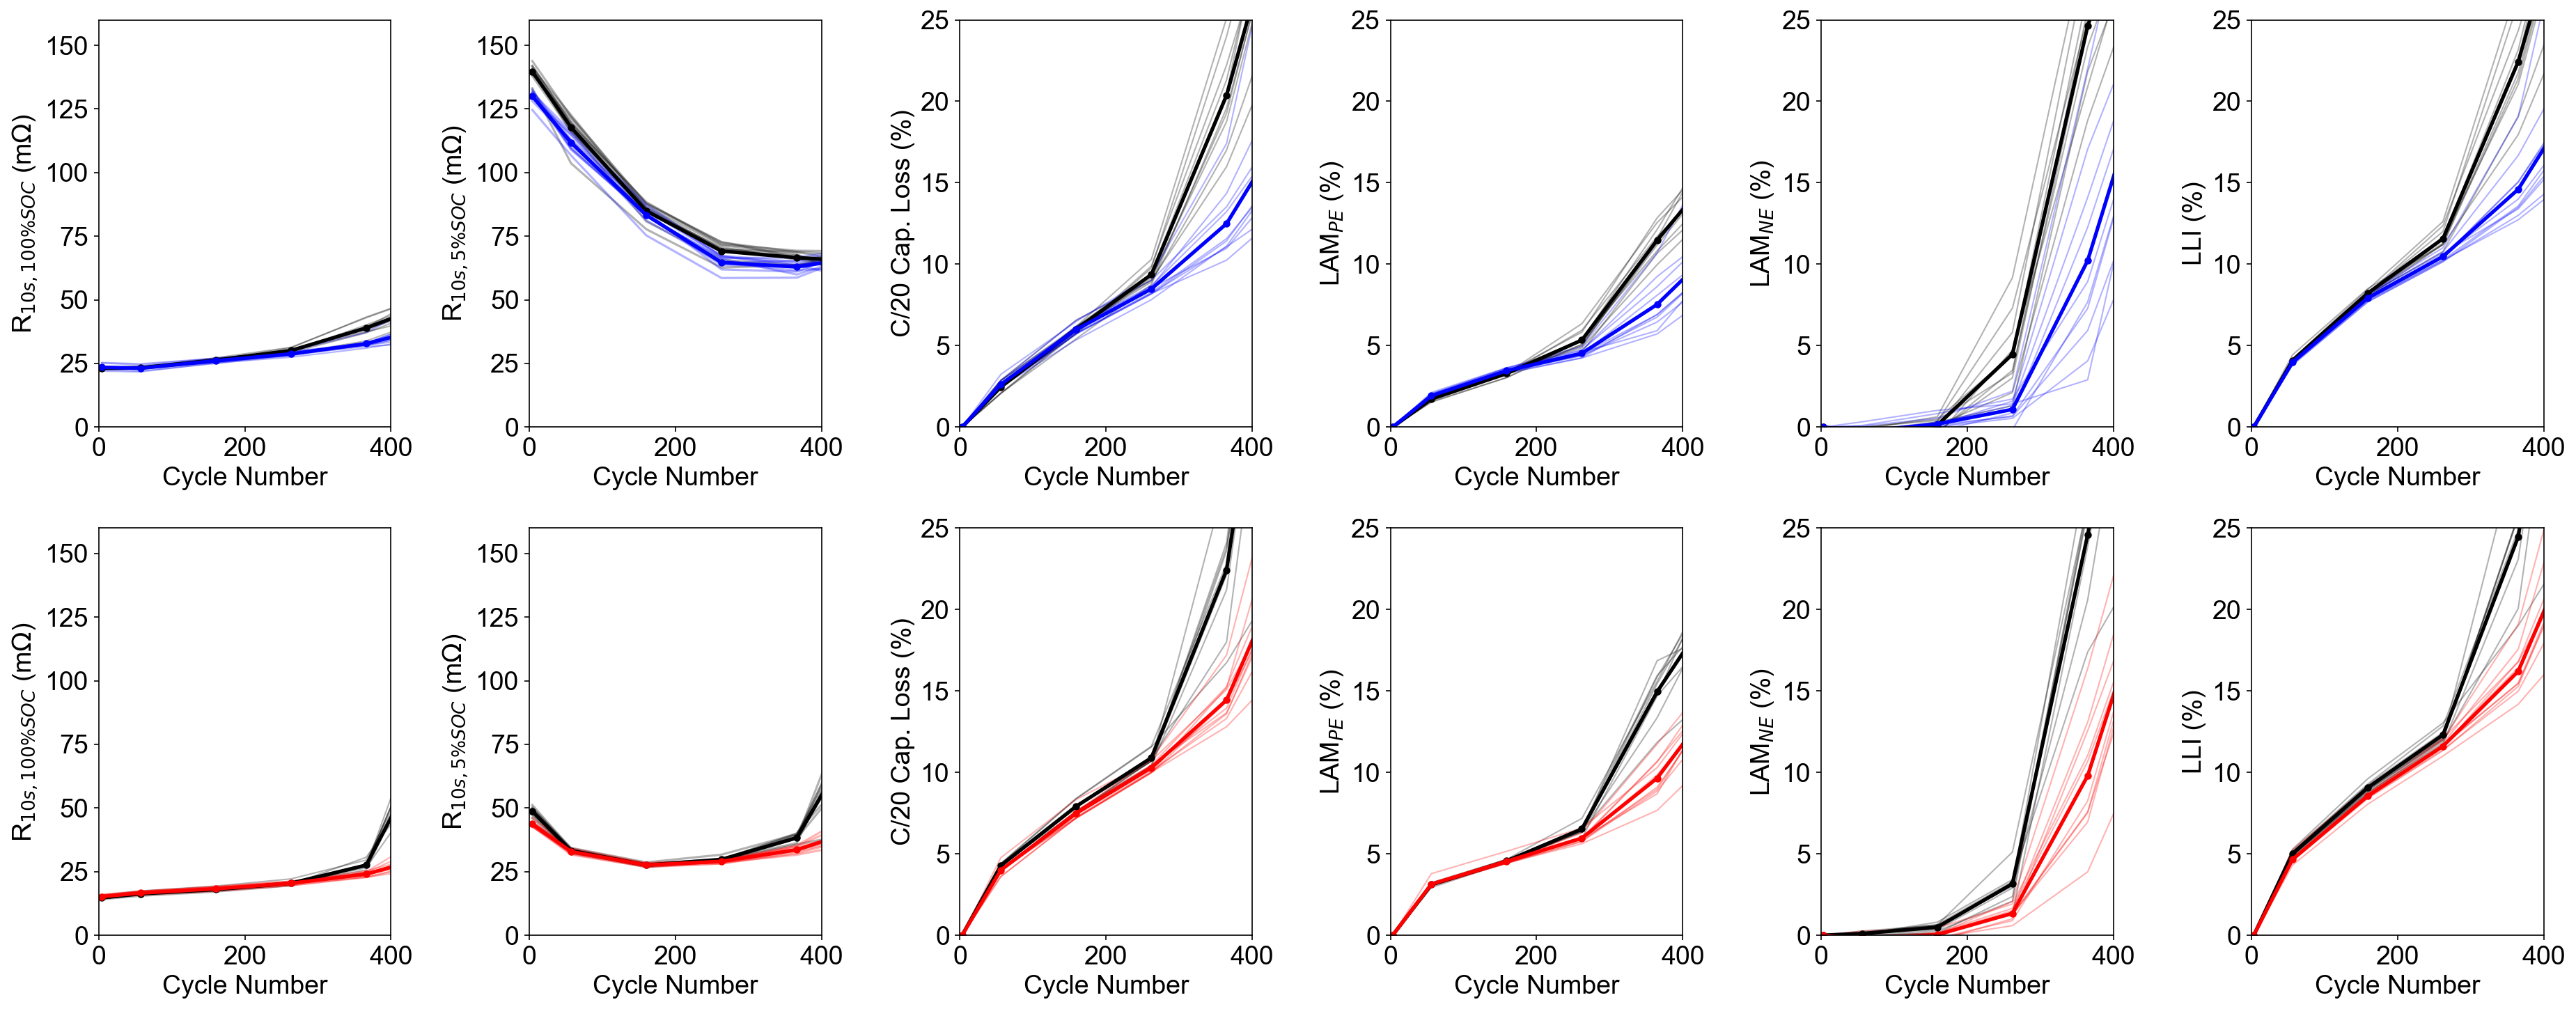

In [34]:
fig, axs = plt.subplots(2, 6, figsize=(25,10))

alpha = 0.3

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue

    (df_hppc, _) = cell.summarize_hppc_pulse_statistics()
    df_esoh_curr = df_esoh[df_esoh['cellid'] == cell.cellid]
    
    if cell.is_room_temp():    
        color = 'k' if cell.is_baseline_formation() else 'b'
        i = 0
    else:
        color = 'k' if cell.is_baseline_formation() else 'r'
        i = 1
        
    axs[i,0].plot(df_hppc['cycle_index'], df_hppc['dcr_10s_soc_100']*1000, 
                color=color, linewidth=1,alpha=alpha)   
    axs[i,1].plot(df_hppc['cycle_index'], df_hppc['dcr_10s_soc_5']*1000, 
                color=color, markersize=4, alpha=alpha)
    axs[i,2].plot(df_esoh_curr['cycle_number'], df_esoh_curr['c20_loss'],
                color=color, linewidth=1,alpha=alpha) 
    axs[i,3].plot(df_esoh_curr['cycle_number'], df_esoh_curr['lam_pe'], 
                color=color, linewidth=1, alpha=alpha)   
    axs[i,4].plot(df_esoh_curr['cycle_number'], df_esoh_curr['lam_ne'], 
                color=color, linewidth=1, alpha=alpha)
    axs[i,5].plot(df_esoh_curr['cycle_number'], df_esoh_curr['lli'], 
                color=color, linewidth=1, alpha=alpha)
    
add_mean_line(axs[0, 0], df_hppc_rt_base, 'dcr_10s_soc_100', 'k')
add_mean_line(axs[0, 1], df_hppc_rt_base, 'dcr_10s_soc_5', 'k')
add_mean_line(axs[0, 2], df_esoh_rt_base, 'c20_loss', 'k')
add_mean_line(axs[0, 3], df_esoh_rt_base, 'lam_pe', 'k')
add_mean_line(axs[0, 4], df_esoh_rt_base, 'lam_ne', 'k')
add_mean_line(axs[0, 5], df_esoh_rt_base, 'lli', 'k')

add_mean_line(axs[0, 0], df_hppc_rt_fast, 'dcr_10s_soc_100', 'b')
add_mean_line(axs[0, 1], df_hppc_rt_fast, 'dcr_10s_soc_5', 'b')
add_mean_line(axs[0, 2], df_esoh_rt_fast, 'c20_loss', 'b')
add_mean_line(axs[0, 3], df_esoh_rt_fast, 'lam_pe', 'b')
add_mean_line(axs[0, 4], df_esoh_rt_fast, 'lam_ne', 'b')
add_mean_line(axs[0, 5], df_esoh_rt_fast, 'lli', 'b')

add_mean_line(axs[1, 0], df_hppc_ht_base, 'dcr_10s_soc_100', 'k')
add_mean_line(axs[1, 1], df_hppc_ht_base, 'dcr_10s_soc_5', 'k')
add_mean_line(axs[1, 2], df_esoh_ht_base, 'c20_loss', 'k')
add_mean_line(axs[1, 3], df_esoh_ht_base, 'lam_pe', 'k')
add_mean_line(axs[1, 4], df_esoh_ht_base, 'lam_ne', 'k')
add_mean_line(axs[1, 5], df_esoh_ht_base, 'lli', 'k')

add_mean_line(axs[1, 0], df_hppc_ht_fast, 'dcr_10s_soc_100', 'r')
add_mean_line(axs[1, 1], df_hppc_ht_fast, 'dcr_10s_soc_5', 'r')
add_mean_line(axs[1, 2], df_esoh_ht_fast, 'c20_loss', 'r')
add_mean_line(axs[1, 3], df_esoh_ht_fast, 'lam_pe', 'r')
add_mean_line(axs[1, 4], df_esoh_ht_fast, 'lam_ne', 'r')
add_mean_line(axs[1, 5], df_esoh_ht_fast, 'lli', 'r')


for i in [0, 1]:
    
    axs[i, 0].set(ylabel='R$_{10s, 100\% SOC}$ (m$\Omega$)') 
    axs[i, 1].set(ylabel='R$_{10s, 5\% SOC}$ (m$\Omega$)')
    axs[i, 2].set(ylabel='C/20 Cap. Loss (%)')
    axs[i, 3].set(ylabel='LAM$_{PE}$ (%)')
    axs[i, 4].set(ylabel='LAM$_{NE}$ (%)')
    axs[i, 5].set(ylabel='LLI (%)')
    
    axs[i, 0].set(ylim=(0, 160))
    axs[i, 1].set(ylim=(0, 160))
    axs[i, 2].set(ylim=(0, 25))
    axs[i, 3].set(ylim=(0, 25))
    axs[i, 4].set(ylim=(0, 25))
    axs[i, 5].set(ylim=(0, 25))

[ax.set(xlim=(0, 400), xlabel='Cycle Number') for ax in axs.flatten()]

plt.tight_layout()
plt.savefig('aging_test_metrics.png', dpi=300, facecolor='w')
plt.show()


### C/20 and C/3 discharge capacities

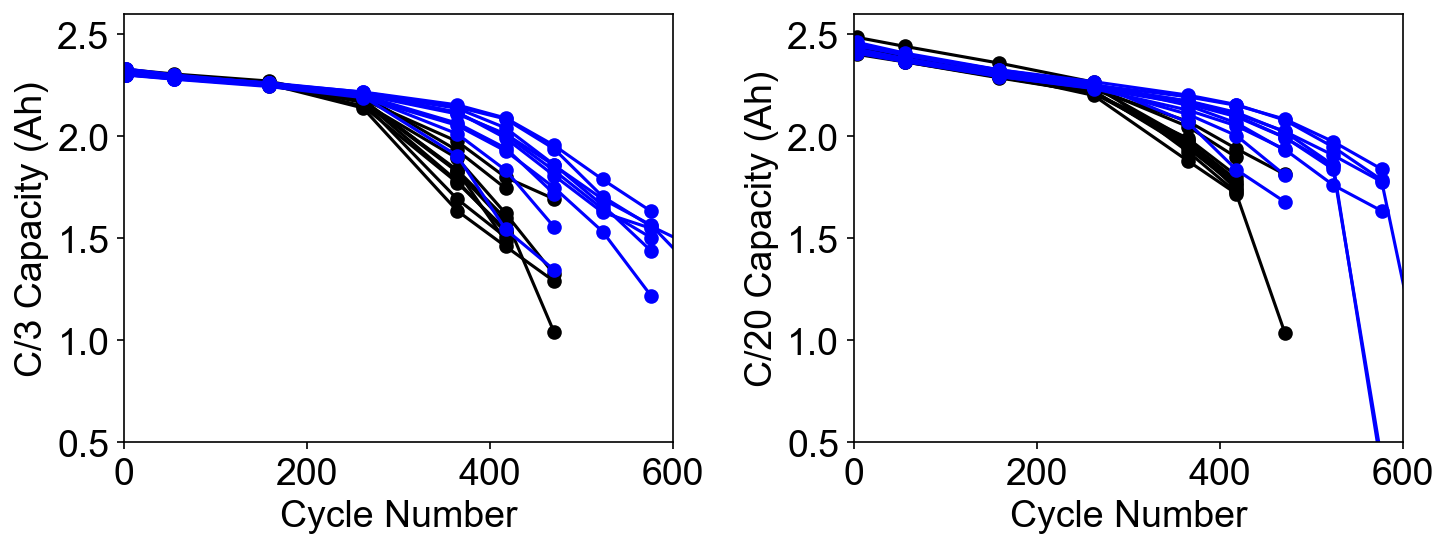

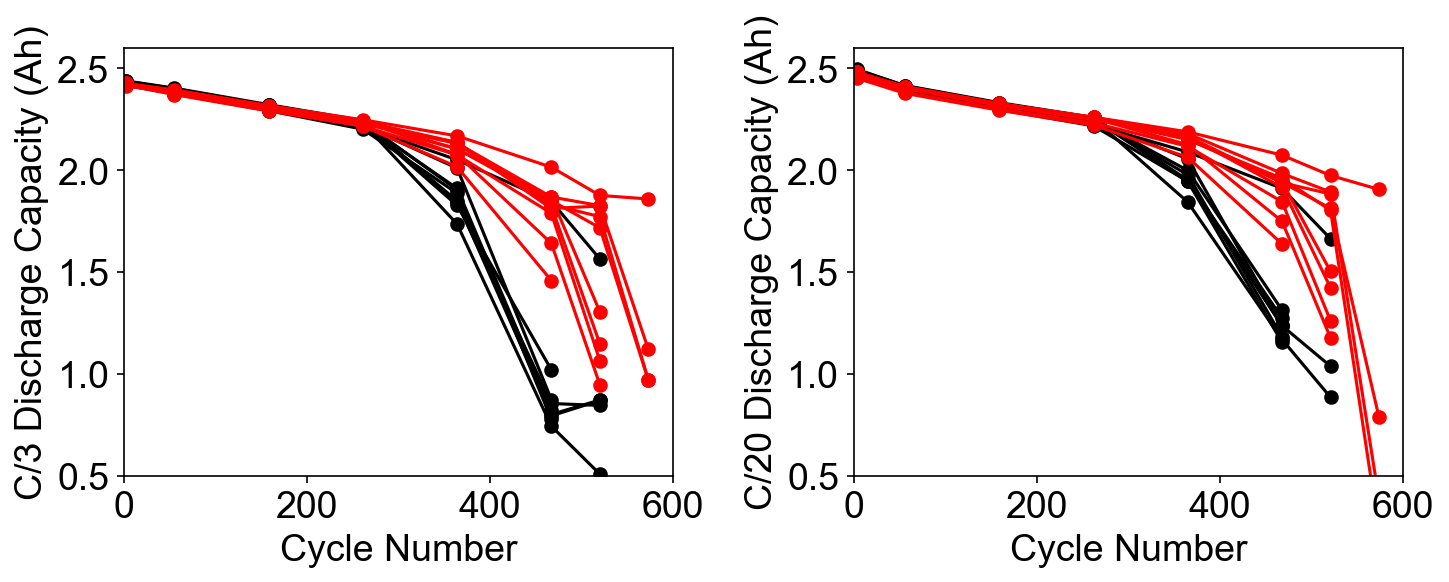

In [29]:
# Room temperature

fig, axs = plt.subplots(1, 2, figsize=(10,4))

for cell in formation_cells:

    if cell.cellid == 9:
        continue
        
    if cell.is_room_temp():
        
        results_c3 = cell.process_diagnostic_c3_data()
        results_c20 = cell.process_diagnostic_c20_data()

        # Unpack the relevant data content for the current cell
        cycle_index_c3 = []
        discharge_capacity_c3 = []
        
        for res in results_c3:
            if not res['dch_capacity'].empty:
                cycle_index_c3.append(res['cycle_index'])
                discharge_capacity_c3.append(res['dch_capacity'].iloc[-1])

        cycle_index_c20 = []
        discharge_capacity_c20 = []
        
        for res in results_c20:
            if not res['dch_capacity'].empty:
                cycle_index_c20.append(res['cycle_index'])
                discharge_capacity_c20.append(res['dch_capacity'].iloc[-1])
                        
        color = (0,0,0) if cell.is_baseline_formation() else (0,0,1)
        axs[0].plot(cycle_index_c3, discharge_capacity_c3, color=color, marker='o')  
        axs[1].plot(cycle_index_c20, discharge_capacity_c20, color=color, marker='o')
        axs[0].set(ylabel='C/3 Capacity (Ah)')
        axs[1].set(ylabel='C/20 Capacity (Ah)')
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           xlim=(0, 600),
           ylim=(0.5, 2.6)
          )

plt.tight_layout()
plt.show()


# High temperatures
fig, axs = plt.subplots(1, 2, figsize=(10,4))

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
    
    if not cell.is_room_temp():
                
        results_c3 = cell.process_diagnostic_c3_data()
        results_c20 = cell.process_diagnostic_c20_data()

        # Unpack the relevant data content for the current cell
        cycle_index_c3 = []
        discharge_capacity_c3 = []
        
        for res in results_c3:
            if not res['dch_capacity'].empty:
                cycle_index_c3.append(res['cycle_index'])
                discharge_capacity_c3.append(res['dch_capacity'].iloc[-1])

        cycle_index_c20 = []
        discharge_capacity_c20 = []
        
        for res in results_c20:
            if not res['dch_capacity'].empty:
                cycle_index_c20.append(res['cycle_index'])
                discharge_capacity_c20.append(res['dch_capacity'].iloc[-1])
        
        color = (0,0,0) if cell.is_baseline_formation() else (1,0,0)
        
        axs[0].plot(cycle_index_c3, discharge_capacity_c3, color=color, marker='o')   
        axs[1].plot(cycle_index_c20, discharge_capacity_c20, color=color, marker='o')
        axs[0].set(ylabel='C/3 Discharge Capacity (Ah)')
        axs[1].set(ylabel='C/20 Discharge Capacity (Ah)')
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           xlim=(0, 600),
           ylim=(0.5, 2.6)
          )

plt.tight_layout()
plt.show()